# Train the CNN/CapsNet, then generate adv examples

In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import torch
from torch import optim

from datasets import get_mnist_dataset, get_data_loader
from utils import *

from cnn import *
from capsnet import *

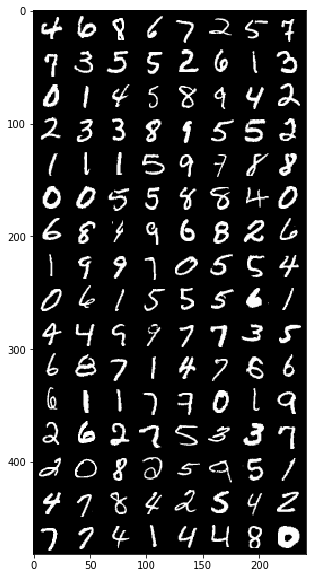

In [3]:
trainset, testset = get_mnist_dataset()
trainloader, testloader = get_data_loader(trainset, testset)
batch, labels = next(iter(trainloader))
plot_batch(batch)

In [4]:
batch_var = Variable(batch.cuda())
labels_var = Variable(one_hotify(labels).cuda())

# Custom tiny CNN

In [22]:
tiny_model = CNN().cuda()
print(count_params(tiny_model))

tiny_optimizer = optim.Adam(tiny_model.parameters())
tiny_loss = nn.CrossEntropyLoss()
tiny_trainer = Trainer(tiny_model, tiny_optimizer, tiny_loss,
                       trainloader, testloader, use_cuda=True)

246506


In [23]:
tiny_trainer.run(epochs=5)

[*] Training for 5 epochs
[*] Epoch 1, TrnLoss: 0.117, TrnAcc: 0.967, TstLoss: 0.065, TstAcc: 0.981
[*] Epoch 2, TrnLoss: 0.037, TrnAcc: 0.988, TstLoss: 0.027, TstAcc: 0.992
[*] Epoch 3, TrnLoss: 0.027, TrnAcc: 0.991, TstLoss: 0.048, TstAcc: 0.985
[*] Epoch 4, TrnLoss: 0.023, TrnAcc: 0.993, TstLoss: 0.035, TstAcc: 0.988
[*] Epoch 5, TrnLoss: 0.017, TrnAcc: 0.995, TstLoss: 0.022, TstAcc: 0.993


# Baseline CNN described in [1]

In [117]:
base_model = BaselineCNN().cuda()
print(count_params(base_model))

base_loss = nn.CrossEntropyLoss()
base_optimizer = optimizer = optim.Adam(base_model.parameters())
base_trainer = Trainer(base_model, base_optimizer, base_loss,
                       trainloader, testloader, use_cuda=True,
                       print_every=50)

35445522


In [118]:
base_trainer.run(epochs=1)

[*] Training for 1 epochs
[*] Iteration 0, Loss: 2.305, Acc: 0.078
[*] Iteration 50, Loss: 0.404, Acc: 0.891
[*] Iteration 100, Loss: 0.321, Acc: 0.953
[*] Iteration 150, Loss: 0.138, Acc: 0.969
[*] Iteration 200, Loss: 0.034, Acc: 1.000
[*] Iteration 250, Loss: 0.147, Acc: 0.961
[*] Iteration 300, Loss: 0.019, Acc: 0.992
[*] Iteration 350, Loss: 0.241, Acc: 0.930
[*] Iteration 400, Loss: 0.069, Acc: 0.984
[*] Iteration 450, Loss: 0.098, Acc: 0.969
[*] Iteration 0, Loss: 0.019, Acc: 1.000
[*] Iteration 50, Loss: 0.039, Acc: 0.984
[*] Epoch 1, TrnLoss: 0.241, TrnAcc: 0.928, TstLoss: 0.074, TstAcc: 0.978


# CapsNet described in [1]

In [20]:
net = CapsuleNetwork().cuda()
decoder = CapsuleDecoder(reconstruction=True).cuda()
caps_model = nn.Sequential(net, decoder)
print(count_params(net))
print(count_params(caps_model))

caps_loss = CapsuleLoss()
caps_optimizer = optim.Adam(caps_model.parameters())
caps_trainer = Trainer(caps_model, caps_optimizer, caps_loss,
                       trainloader, testloader,
                       one_hot=True, use_reconstructions=True, use_cuda=True,
                       print_every=50)

6804224
8215568


In [21]:
caps_trainer.run(epochs=10)
caps_trainer.save_checkpoint('trained_capsnet.pth.tar')

[*] Training for 10 epochs
[*] Batch 0, Loss: 0.640, Acc: 0.070
[*] Batch 50, Loss: 0.523, Acc: 0.844
[*] Batch 100, Loss: 0.485, Acc: 0.922
[*] Batch 150, Loss: 0.477, Acc: 0.938
[*] Batch 200, Loss: 0.471, Acc: 0.938
[*] Batch 250, Loss: 0.462, Acc: 0.969
[*] Batch 300, Loss: 0.460, Acc: 0.977
[*] Batch 350, Loss: 0.462, Acc: 0.961
[*] Batch 400, Loss: 0.458, Acc: 0.977
[*] Batch 450, Loss: 0.459, Acc: 0.977
[*] Batch 0, Loss: 0.454, Acc: 0.992
[*] Batch 50, Loss: 0.453, Acc: 0.992
[*] Epoch 1, TrnLoss: 0.478, TrnAcc: 0.944, TstLoss: 0.457, TstAcc: 0.985
[*] Batch 0, Loss: 0.458, Acc: 0.969
[*] Batch 50, Loss: 0.454, Acc: 1.000
[*] Batch 100, Loss: 0.456, Acc: 0.984
[*] Batch 150, Loss: 0.453, Acc: 1.000
[*] Batch 200, Loss: 0.455, Acc: 0.984
[*] Batch 250, Loss: 0.453, Acc: 1.000
[*] Batch 300, Loss: 0.453, Acc: 0.984
[*] Batch 350, Loss: 0.455, Acc: 0.984
[*] Batch 400, Loss: 0.453, Acc: 0.992
[*] Batch 450, Loss: 0.455, Acc: 0.984
[*] Batch 0, Loss: 0.451, Acc: 0.992
[*] Batch 50,

## Reconstructions

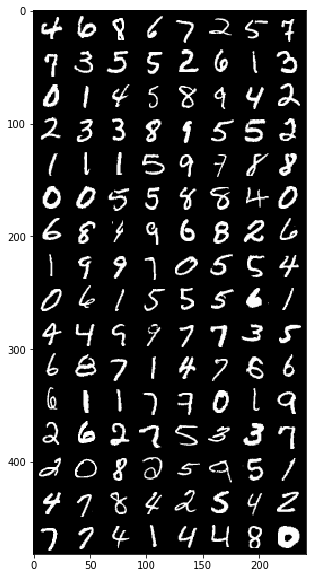

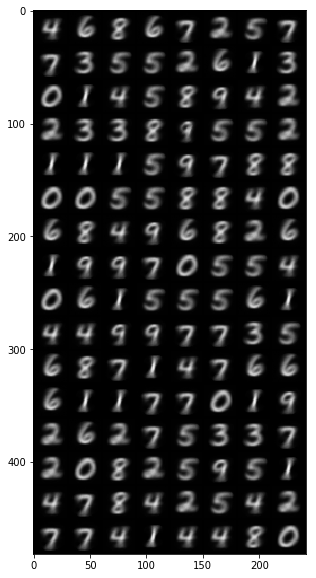

In [24]:
probs, batch_hat = caps_model(batch_var)
plot_batch(batch)
plot_batch(batch_hat.data) # am I messing up the input to the reconstruction network somehow? each class is the same

### References

[1] https://arxiv.org/abs/1710.09829